# Preprocess raw images and store the processed images in the spatialdata.images container with '_preprocessed' suffix

### Define libraries, paths and parameters

In [1]:
# Libraries
import spatialdata as sd
import os
import yaml


import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from dask_image.ndfilters import maximum_filter, minimum_filter, median_filter
import dask.array as da #TODO do this lazily!!
from spatialdata.models import Image2DModel, Labels2DModel, Labels3DModel

from skimage.morphology import remove_small_objects

import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops

def minmax_rescaling(channel: da.array, feature_range:tuple=(0, 1), dtype=np.float32) -> da.array:

    # Convert to float32 so we can divide by max value without losing information
    channel = channel.astype(np.float32)

    # Rescale image to 0-1 range
    min_value, max_value = da.min(channel), da.max(channel)
    channel = (channel - min_value) / (max_value - min_value)

    # Rescale image to feature range
    channel = channel * (feature_range[1] - feature_range[0]) + feature_range[0]

    return channel.astype(dtype)



def get_cut_mask(dapi_channel: da.array, median_value: int, threshold_quartile:int = 70) -> da.array:
    """Get cut mask from dapi channel by thresholding and removing small objects"""

    # Assess intensity threshold value
    q65 = np.percentile(dapi_channel[dapi_channel > median_value].flatten(), threshold_quartile)

    # Threshold and clean dapi channel
    threshed_dapi = dapi_channel > q65
    threshed_dapi = cv2.morphologyEx(threshed_dapi.astype(np.uint8).compute(), cv2.MORPH_CLOSE, np.ones((30, 30), np.uint8)) # TODO fix full read!!!!
    threshed_dapi = binary_fill_holes(threshed_dapi)

    # get area of largest object
    segment_props = regionprops(label(threshed_dapi))
    max_area = np.max([prop.area for prop in segment_props])

    # allow only largest segment
    cut_segment = remove_small_objects(threshed_dapi, min_size=max_area * 0.9) # regionprops.area seems to make slight mistakes sometimes => 0.9 scalar to compensate

    return da.asarray(cut_segment)


In [2]:
#Paths
sample_type = 'Flox_Control'
data_dir = '/srv/data/michielvc/data/CSF1_ligand_data/SpatialData/'

# open config file and extract relevant information
config = yaml.safe_load(open(data_dir + f'{sample_type}_config.yaml'))
file_names = config['file_names']

# Parameters
minmax_filter_size = tuple(config['minmax_filter_size'])
contrast_clip = 3.5
clahe = cv2.createCLAHE(clipLimit=contrast_clip, tileGridSize=(8, 8))
# artifact_size_threshold = config['artifact_size_threshold']
artifact_size_threshold = 250

### Load data as SpatialData Object

In [3]:
sdata = sd.read_zarr(os.path.join(data_dir, f'{sample_type}.sd'))
sdata

SpatialData object with:
├── Images
│     ├── 'E2M1FloxControl_preprocessed': SpatialImage[cyx] (5, 7533, 16659)
│     ├── 'E2M1FloxControl_raw': SpatialImage[cyx] (5, 7533, 16659)
│     ├── 'E2M3FloxControl_preprocessed': SpatialImage[cyx] (5, 11178, 18468)
│     ├── 'E2M3FloxControl_raw': SpatialImage[cyx] (5, 11178, 18468)
│     ├── 'E2M5FloxControl_preprocessed': SpatialImage[cyx] (5, 9342, 12987)
│     ├── 'E2M5FloxControl_raw': SpatialImage[cyx] (5, 9342, 12987)
│     ├── 'E2M6FloxControl_preprocessed': SpatialImage[cyx] (5, 11205, 14823)
│     ├── 'E2M6FloxControl_raw': SpatialImage[cyx] (5, 11205, 14823)
│     ├── 'E2M7FloxControl_preprocessed': SpatialImage[cyx] (5, 9342, 16632)
│     ├── 'E2M7FloxControl_raw': SpatialImage[cyx] (5, 9342, 16632)
│     ├── 'E2M8FloxControl_preprocessed': SpatialImage[cyx] (5, 7533, 14823)
│     ├── 'E2M8FloxControl_raw': SpatialImage[cyx] (5, 7533, 14823)
│     ├── 'E2M15FloxControl_preprocessed': SpatialImage[cyx] (5, 9342, 14823)
│     ├── 'E

### Perform preprocessing and save preprocessed image in same SpatialData object
Preprocessing steps:

    - Tiling Correction TODO
    - Outlier removal (i.e. extremely fluorescent imaging artefacts such as dust particles)
    - Minmax Filtering
    - Median filtering
    - Histogram equalization
    - Normalization/ minmax rescale?

In [4]:
# select raw image file
nb_of_files = len(file_names)
for count, file_name in enumerate(file_names, start = 1):
    image = sdata.images[file_name + '_raw'].data
    nb_channels, y_size, x_size = image.shape

    artefact_masks_array = da.empty_like(image, dtype=bool)
    preprocessed_image = da.empty_like(image, dtype=np.uint16)   

    print(f'Preprocessing: Currently working on {file_name}: {count} of {nb_of_files}')
    
    for i in range(nb_channels):

        # Tiling Correction
        # TODO

        # Minmax filtering
        channel_filter = minimum_filter(image[i], minmax_filter_size)
        filtered_chanel = image[i] - maximum_filter(channel_filter, minmax_filter_size)

        # Detect outliers, compensate them and store their segments in SpatialData.labels
        median_value = np.percentile(filtered_chanel.flatten(), 50)
        # Outliers can only be very high => ignore lower-than-median values
        q95 = np.percentile(filtered_chanel[filtered_chanel > median_value].flatten(), 95)[0]
        outliers = filtered_chanel > q95 # define outliers as bigger than 95th quantile
        # Replace outliers with maximally allowed value
        filtered_chanel[outliers] = np.int32(q95)

        # Get larger artefacts from outliers and store them in artefact_masks_array
        larger_artefacts = remove_small_objects(outliers.compute(), min_size=artifact_size_threshold)
        artefact_masks_array[i] = da.asarray(larger_artefacts, dtype=bool)

        # Clahe 
        contr_enhanhanced_image = clahe.apply(filtered_chanel.compute())  #BAD! TODO This reads full array in memory! Make it lazy! 
        
        # Normalize to 0-65535 range
        rescaled_image = minmax_rescaling(contr_enhanhanced_image, feature_range=(0, 65535), dtype=np.uint16)

        # Put back in dask array
        preprocessed_image[i] = da.asarray(rescaled_image)
        
        # Use dapi channel to create cut mask
        if i == 0:
            cut_mask = get_cut_mask(dapi_channel=rescaled_image, median_value=median_value)
            sdata.add_labels(name=file_name + '_cut_mask', labels=Labels2DModel.parse(cut_mask), overwrite=True)


    # Add to SpatialData object as preprocessed image
    sdata.add_image(name=file_name + '_preprocessed', image=Image2DModel.parse(preprocessed_image), overwrite=True)
    sdata.add_labels(name=file_name + '_artefacts', labels=Labels3DModel.parse(artefact_masks_array), overwrite=True) # 3D because of c-stack

Preprocessing: Currently working on E2M1FloxControl: 1 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170e4f5e0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb17174dac0>: None


Preprocessing: Currently working on E2M15FloxControl: 2 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170c924c0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170b377f0>: None


Preprocessing: Currently working on E2M16FloxControl: 3 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170b65430>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170c91c70>: None


Preprocessing: Currently working on E2M3FloxControl: 4 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170c941c0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170965160>: None


Preprocessing: Currently working on E2M5FloxControl: 5 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb17086cbb0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb1716e1fa0>: None


Preprocessing: Currently working on E2M6FloxControl: 6 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1709d5f10>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170991b20>: None


Preprocessing: Currently working on E2M7FloxControl: 7 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170956f70>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb1709bbd00>: None


Preprocessing: Currently working on E2M8FloxControl: 8 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170e0f280>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170c9b040>: None


Preprocessing: Currently working on E5M22FloxControl: 9 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1709680d0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170a510d0>: None


Preprocessing: Currently working on E5M1FloxControl: 10 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb17084cd00>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170874b50>: None


Preprocessing: Currently working on E5M13FloxControl: 11 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170b63910>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170b18130>: None


Preprocessing: Currently working on E4M14FloxControl: 12 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1709e1b80>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170b0f580>: None


Preprocessing: Currently working on E4M16FloxControl: 13 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170b0f100>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb1709cfcd0>: None


Preprocessing: Currently working on E4M18FloxControl: 14 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1715a9190>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170aab430>: None


Preprocessing: Currently working on E4M7FloxControl: 15 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170840490>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170a2c640>: None


Preprocessing: Currently working on E5M19FloxControl: 16 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb170cfb340>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb17087d220>: None


Preprocessing: Currently working on E5M20FloxControl: 17 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1708ca4c0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170840370>: None


Preprocessing: Currently working on E5M23FloxControl: 18 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1716a4730>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb0f81bcbb0>: None


Preprocessing: Currently working on E5M2FloxControl: 19 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1716edbe0>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170b07040>: None


Preprocessing: Currently working on E5M4FloxControl: 20 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb171575f70>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb0fbfe96d0>: None


Preprocessing: Currently working on E5M6FloxControl: 21 of 21
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


no parent found for <ome_zarr.reader.Label object at 0x7fb1716a4850>: None


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


no parent found for <ome_zarr.reader.Label object at 0x7fb170ccd820>: None


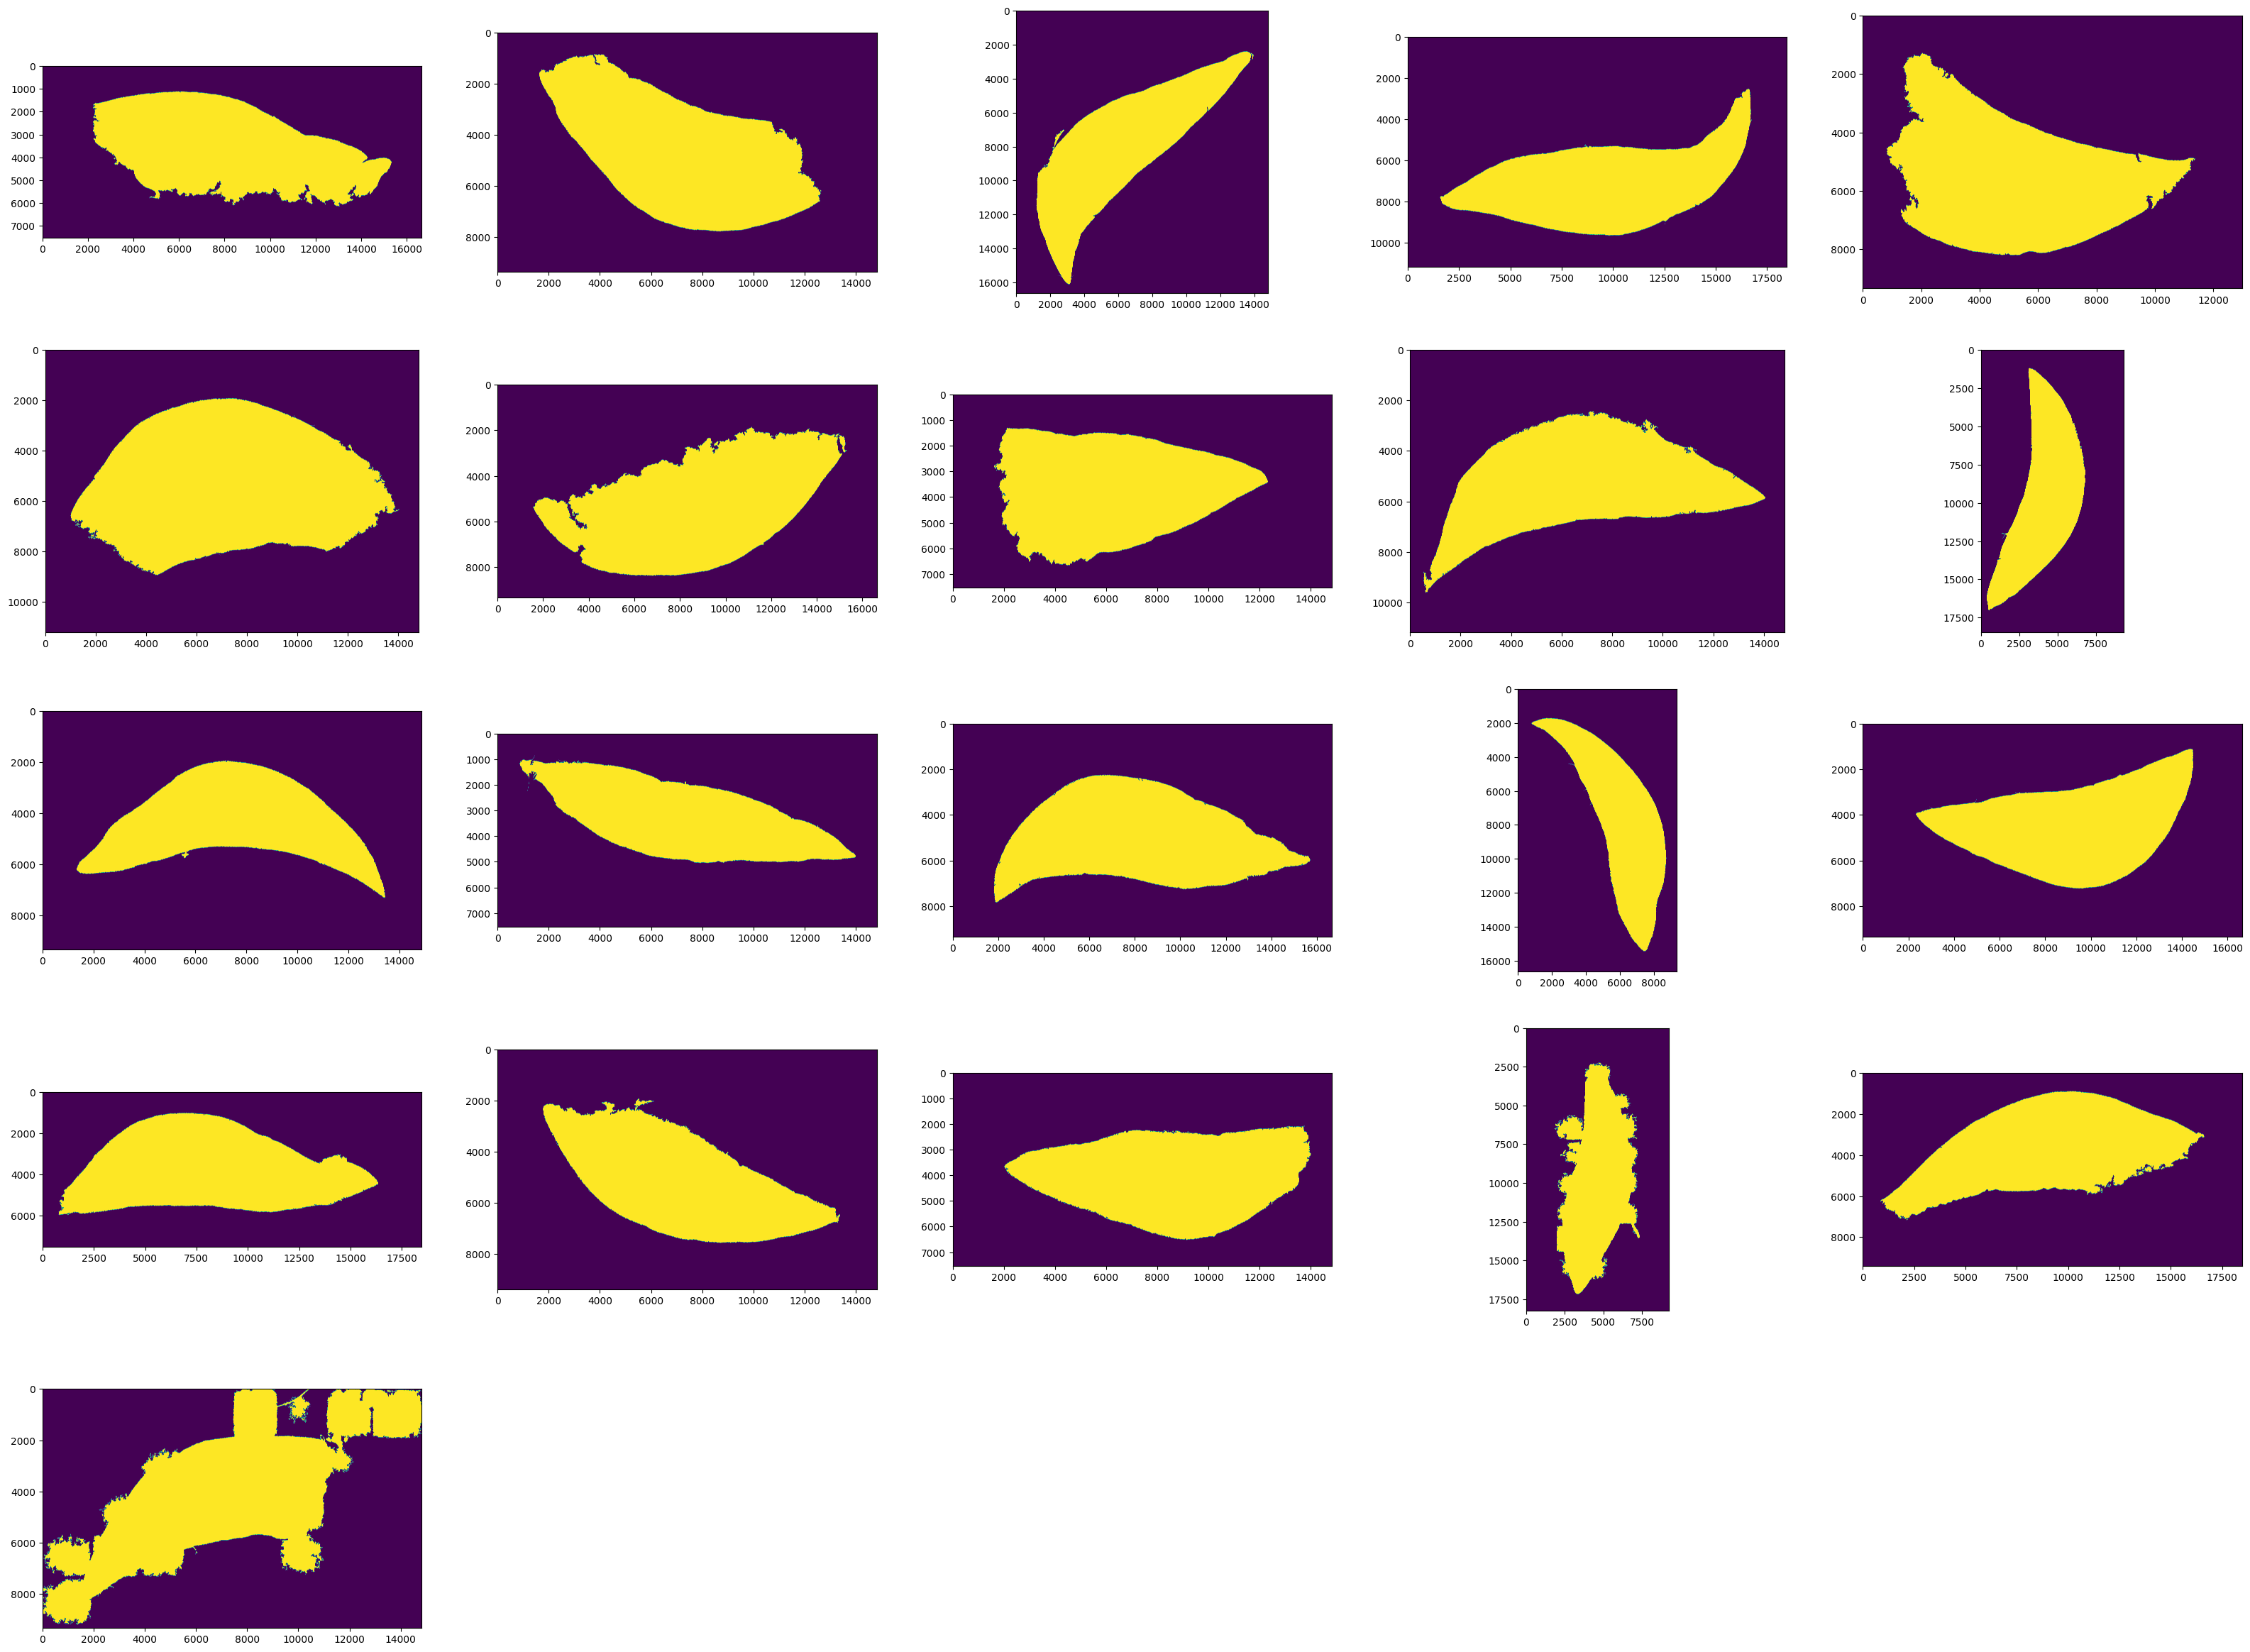

In [5]:
plt.figure(figsize=(40,30))

for i, file_name in enumerate(file_names, start=1):
    plt.subplot(5,5,i)
    plt.imshow(sdata.labels[file_name + '_cut_mask'].data)